# 唐宇迪K-Means和DBSCAN的红酒demo
https://blog.csdn.net/weixin_43326122/article/details/106362866

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
%matplotlib inline     

In [3]:
beer = pd.read_csv(r"./beer_data.txt", sep=' ')
print(beer)
X = beer[['calories', 'sodium', 'alcohol', 'cost']]

                    name  calories  sodium  alcohol  cost
0              Budweiser       144      15      4.7  0.43
1                Schlitz       151      19      4.9  0.43
2              Lowenbrau       157      15      0.9  0.48
3            Kronenbourg       170       7      5.2  0.73
4               Heineken       152      11      5.0  0.77
5          Old_Milwaukee       145      23      4.6  0.28
6             Augsberger       175      24      5.5  0.40
7   Srohs_Bohemian_Style       149      27      4.7  0.42
8            Miller_Lite        99      10      4.3  0.43
9        Budweiser_Light       113       8      3.7  0.40
10                 Coors       140      18      4.6  0.44
11           Coors_Light       102      15      4.1  0.46
12        Michelob_Light       135      11      4.2  0.50
13                 Becks       150      19      4.7  0.76
14                 Kirin       149       6      5.0  0.79
15     Pabst_Extra_Light        68      15      2.3  0.38
16            

# 一、K-Means聚类
## 1.1 训练一个基本的k-means

                    name  calories  sodium  alcohol  cost  cluster
0              Budweiser       144      15      4.7  0.43        0
1                Schlitz       151      19      4.9  0.43        0
2              Lowenbrau       157      15      0.9  0.48        0
3            Kronenbourg       170       7      5.2  0.73        0
4               Heineken       152      11      5.0  0.77        0
5          Old_Milwaukee       145      23      4.6  0.28        0
6             Augsberger       175      24      5.5  0.40        0
7   Srohs_Bohemian_Style       149      27      4.7  0.42        0
8            Miller_Lite        99      10      4.3  0.43        1
9        Budweiser_Light       113       8      3.7  0.40        1
10                 Coors       140      18      4.6  0.44        0
11           Coors_Light       102      15      4.1  0.46        1
12        Michelob_Light       135      11      4.2  0.50        0
13                 Becks       150      19      4.7  0.76     

Text(0, 0.5, 'Alcohol')

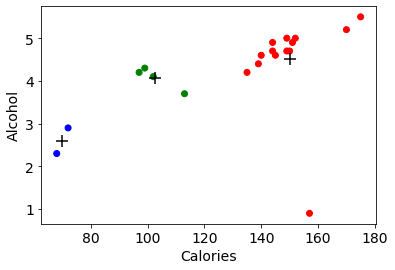

In [4]:
km = KMeans(n_clusters=3).fit(X)  # n_clusters=3意思为分3簇

beer['cluster'] = km.labels_    # 将训练结果新增到beer的cluster列（0-1-2-1-2-0-2-2-1......）
print(beer)

plt.rcParams['font.size'] = 14     # 设置绘图样式plt字体大小
colors = np.array(['red', 'green', 'blue', 'yellow'])     # 簇为0位red，簇为1位green

# 画data
plt.scatter(beer['calories'], beer['alcohol'], c=colors[beer['cluster']])
# 画中心点
centers = beer.groupby('cluster').mean().reset_index()   # 每个簇的原始数据计算各个属性平均值
plt.scatter(centers['calories'], centers['alcohol'], marker='+', s=150, c='black')

plt.xlabel('Calories')
plt.ylabel('Alcohol')

## 1.2 多维度发现k-means
基于上一步，使用矩阵散点图scatter_matrix判断哪几个维度适合分类k-means

Text(0.5, 0.98, 'With 3 centroids initialized')

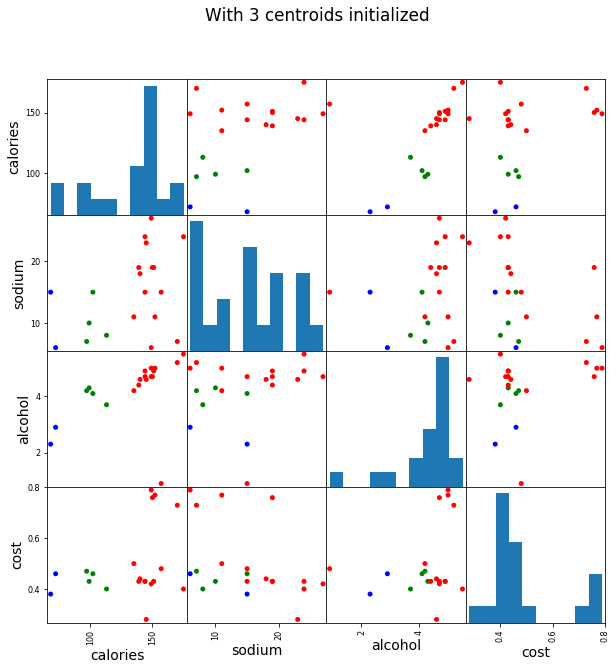

In [5]:
from pandas.plotting import scatter_matrix    # 使用sklearn的scatter_matrix多维度发现
scatter_matrix(beer[['calories', 'sodium', 'alcohol', 'cost']], s=100, alpha=1, c=colors[beer['cluster']], figsize=(10,10))
plt.suptitle('With 3 centroids initialized')

# 1.3 再归一化原始数据
如果不归一化，那些一百多数值的会被系统认为很重要，那些零点几数值的会被认为不重要。
一般归一化后效果会好，但也说不准，玄学。

Text(0.5, 0.98, 'With 2 centroids initialized')

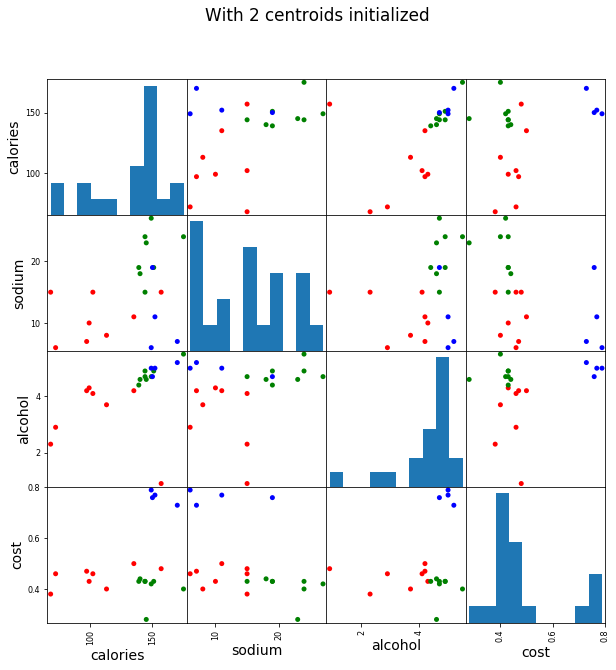

In [6]:
from sklearn.preprocessing import StandardScaler      # 导入sklearn的库，直接就可以归一化，很方便。
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # 直接输入原始数据进去就可以，X_scaled就是归一化后的了
km = KMeans(n_clusters=3).fit(X_scaled)   
beer['scaled_cluster'] = km.labels_

scatter_matrix(beer[['calories', 'sodium', 'alcohol', 'cost']], s=100, alpha=1, c=colors[beer['scaled_cluster']], figsize=(10,10))
plt.suptitle('With 2 centroids initialized')

# 1.4 使用轮廓系数评估聚类效果
总得有个方法能够表达出算法聚类出来的效果如何，轮廓系数就可以。
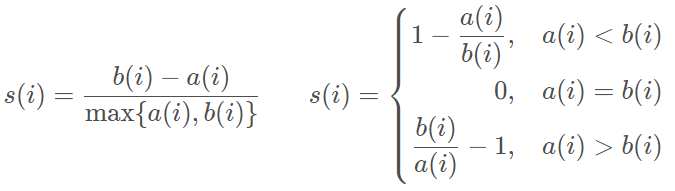
ai指样本i到同簇其他样本的平均距离，越小说明聚类效果越好
bi指样本i到其他某簇的所有样本的平均距离，越大说明效果越好
综上所述，si解决1说明效果越好，接近-1说明一塌糊涂

In [7]:
from sklearn import metrics     # 直接导入库即可使用
score_scaled = metrics.silhouette_score(X, beer['scaled_cluster'])      # 传入原始数据，再传入聚类标签，函数就会开始计算轮廓系数si
score = metrics.silhouette_score(X, beer['cluster'])        #上面一行是归一化后的，这个是没归一化的
print(score_scaled, score)   # 从结果看出不一定归一化后效果更好

0.1797806808940007 0.6731775046455796


# 1.5 k-means选择到底分几簇合适
根据上面的评估函数，一次一次试kmeans分为几簇时轮廓系数最接近1，最接近一次就是聚类效果最好的一次

Text(0, 0.5, 'Silhouette Score')

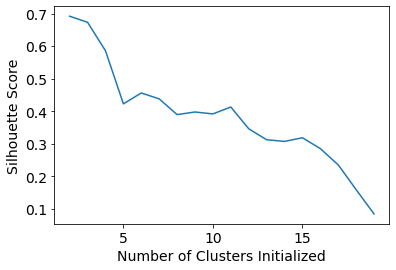

In [8]:
scores = []
for i in range(2, 20):
    # KMeans分类结果
    labels = KMeans(n_clusters=i).fit(X).labels_
    # 轮廓系数评估
    score = metrics.silhouette_score(X, labels)
    scores.append(score)

# 可视化
plt.plot(range(2, 20), scores)
plt.xlabel("Number of Clusters Initialized")
plt.ylabel("Silhouette Score")

# 二、DBSCAN
## 2.1 训练一个基本的DBSCAN

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C1911A5848>,
      dtype=object)

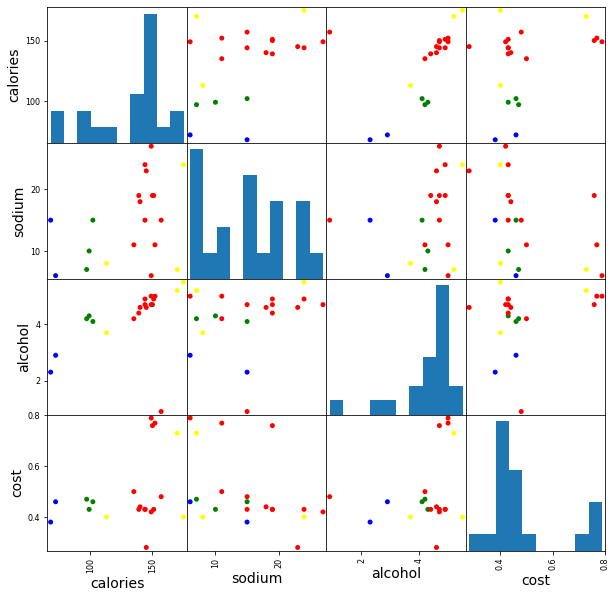

In [9]:
from sklearn.cluster import DBSCAN
# eps半径 min_samples最小个数
db = DBSCAN(eps=10, min_samples=2).fit(X)
beer['cluster_db'] = db.labels_
# 绘制矩阵散点图
scatter_matrix(beer[['calories', 'sodium', 'alcohol', 'cost']], s=100, alpha=1, c=colors[beer['cluster_db']], figsize=(10,10))

## 2.2 选取最优的参数
使用轮廓系数作为评估函数取出最好的参数（DBSCAN的半径，DBSCAN的阈值）

0.6731775046455796


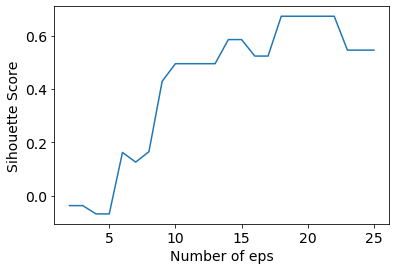

In [9]:
# eps半径这个参数取几好呢
scores = []
for eps in range(2, 26):  # 26以后labels=[0,0,0...]
    labels = DBSCAN(eps=eps, min_samples=2).fit(X).labels_
    score = metrics.silhouette_score(X, labels)
    scores.append(score)
plt.plot(range(2, 26), scores)
plt.xlabel('Number of eps')
plt.ylabel('Sihouette Score')
print(max(scores))

0.6731775046455796


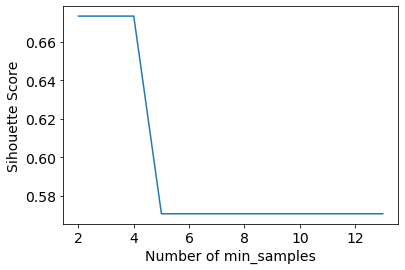

In [10]:
# DBSCAN阈值设为多少最好呢
scores = []
for k in range(2, 14):  # 14以后labels=[-1,-1...]
    labels = DBSCAN(eps=20, min_samples=k).fit(X).labels_
    score = metrics.silhouette_score(X, labels)
    scores.append(score)
plt.plot(range(2, 14), scores)
plt.xlabel('Number of min_samples')
plt.ylabel('Sihouette Score')
print(max(scores))